In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from scipy.stats import chisquare

In [5]:
pip install pyarrow

     --------------------------------------- 19.6/19.6 MB 36.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install fastparquet

     -------------------------------------- 605.7/605.7 kB 9.6 MB/s eta 0:00:00
     ------------------------------------- 993.4/993.4 kB 10.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [7]:
import fastparquet
import pyarrow

In [3]:
pwd

'C:\\Users\\19172'

In [8]:
df = pd.read_parquet('C:\\Users\\19172\\Desktop\\Traffic\\traffic.parquet')

In [9]:
print(df['subject_race'].unique().tolist())
# Delete rows with 'unknown' and 'nan' for 'subject_race'
df = df[df['subject_race'] != 'unknown']
df = df[df['subject_race'] != 'other']
df = df[df['subject_race'].notna()]

['white', 'hispanic', 'black', 'asian/pacific islander', 'unknown', 'other', nan]


In [10]:
count_df = pd.DataFrame(columns=['Race',
                                 'Total',
                                 'Warning=0_Citation=0',
                                 'Warning=0_Citation=1',
                                 'Warning=1_Citation=0',
                                 'Warning=1_Citation=1'])
count_df['Race'] = df['subject_race'].unique().tolist()
count_df

,Race,Total,Warning=0_Citation=0,Warning=0_Citation=1,Warning=1_Citation=0,Warning=1_Citation=1
0,white,NaN,NaN,NaN,NaN,NaN
1,hispanic,NaN,NaN,NaN,NaN,NaN
2,black,NaN,NaN,NaN,NaN,NaN
3,asian/pacific islander,NaN,NaN,NaN,NaN,NaN


In [11]:
for race in df['subject_race'].unique().tolist():
    race_df = df[df['subject_race'] == race]
    count_df.loc[count_df['Race'] == race, 'Total'] = len(race_df)
    count_df.loc[count_df['Race'] == race, 'Warning=0_Citation=0'] = len(race_df.query('warning_issued==False & citation_issued==False'))
    count_df.loc[count_df['Race'] == race, 'Warning=0_Citation=1'] = len(race_df.query('warning_issued==False & citation_issued==True'))
    count_df.loc[count_df['Race'] == race, 'Warning=1_Citation=0'] = len(race_df.query('warning_issued==True & citation_issued==False'))
    count_df.loc[count_df['Race'] == race, 'Warning=1_Citation=1'] = len(race_df.query('warning_issued==True & citation_issued==True'))

print(count_df.to_string(index=False))

                  Race    Total Warning=0_Citation=0 Warning=0_Citation=1 Warning=1_Citation=0 Warning=1_Citation=1
                 white 15418027                 1021              3473755             10133830              1809421
              hispanic  8236546                  999              1917773              4790166              1527608
                 black  2723187                  148               657798              1607268               457973
asian/pacific islander   413119                   29               127297               243679                42114


In [15]:
percentage_dict = {}

for race in ['white', 'black', 'hispanic', 'asian/pacific islander']:
    percentage_dict[race] = []
    percentage_dict[race].append(100 * count_df[count_df['Race'] == race]['Warning=0_Citation=0'].values[0] / count_df[count_df['Race'] == race]['Total'].values[0])
    percentage_dict[race].append(100 * count_df[count_df['Race'] == race]['Warning=1_Citation=0'].values[0] / count_df[count_df['Race'] == race]['Total'].values[0])
    percentage_dict[race].append(100 * count_df[count_df['Race'] == race]['Warning=0_Citation=1'].values[0] / count_df[count_df['Race'] == race]['Total'].values[0])
    percentage_dict[race].append(100 * count_df[count_df['Race'] == race]['Warning=1_Citation=1'].values[0] / count_df[count_df['Race'] == race]['Total'].values[0])

In [16]:
percentage_dict

{'white': [0.006622118381294831,
  65.72715172959549,
  22.530476824304433,
  11.73574932771878],
 'black': [0.005434808553360456,
  59.02158022934157,
  24.15544727556352,
  16.81753768654154],
 'hispanic': [0.01212887052412504,
  58.15746066372967,
  23.28370411577863,
  18.54670634996757],
 'asian/pacific islander': [0.00701976912221418,
  58.985183445932044,
  30.813639653465465,
  10.194157131480276]}

In [18]:
def autolabel(rects, ax, format_str):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(format_str.format(height/100),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=16)

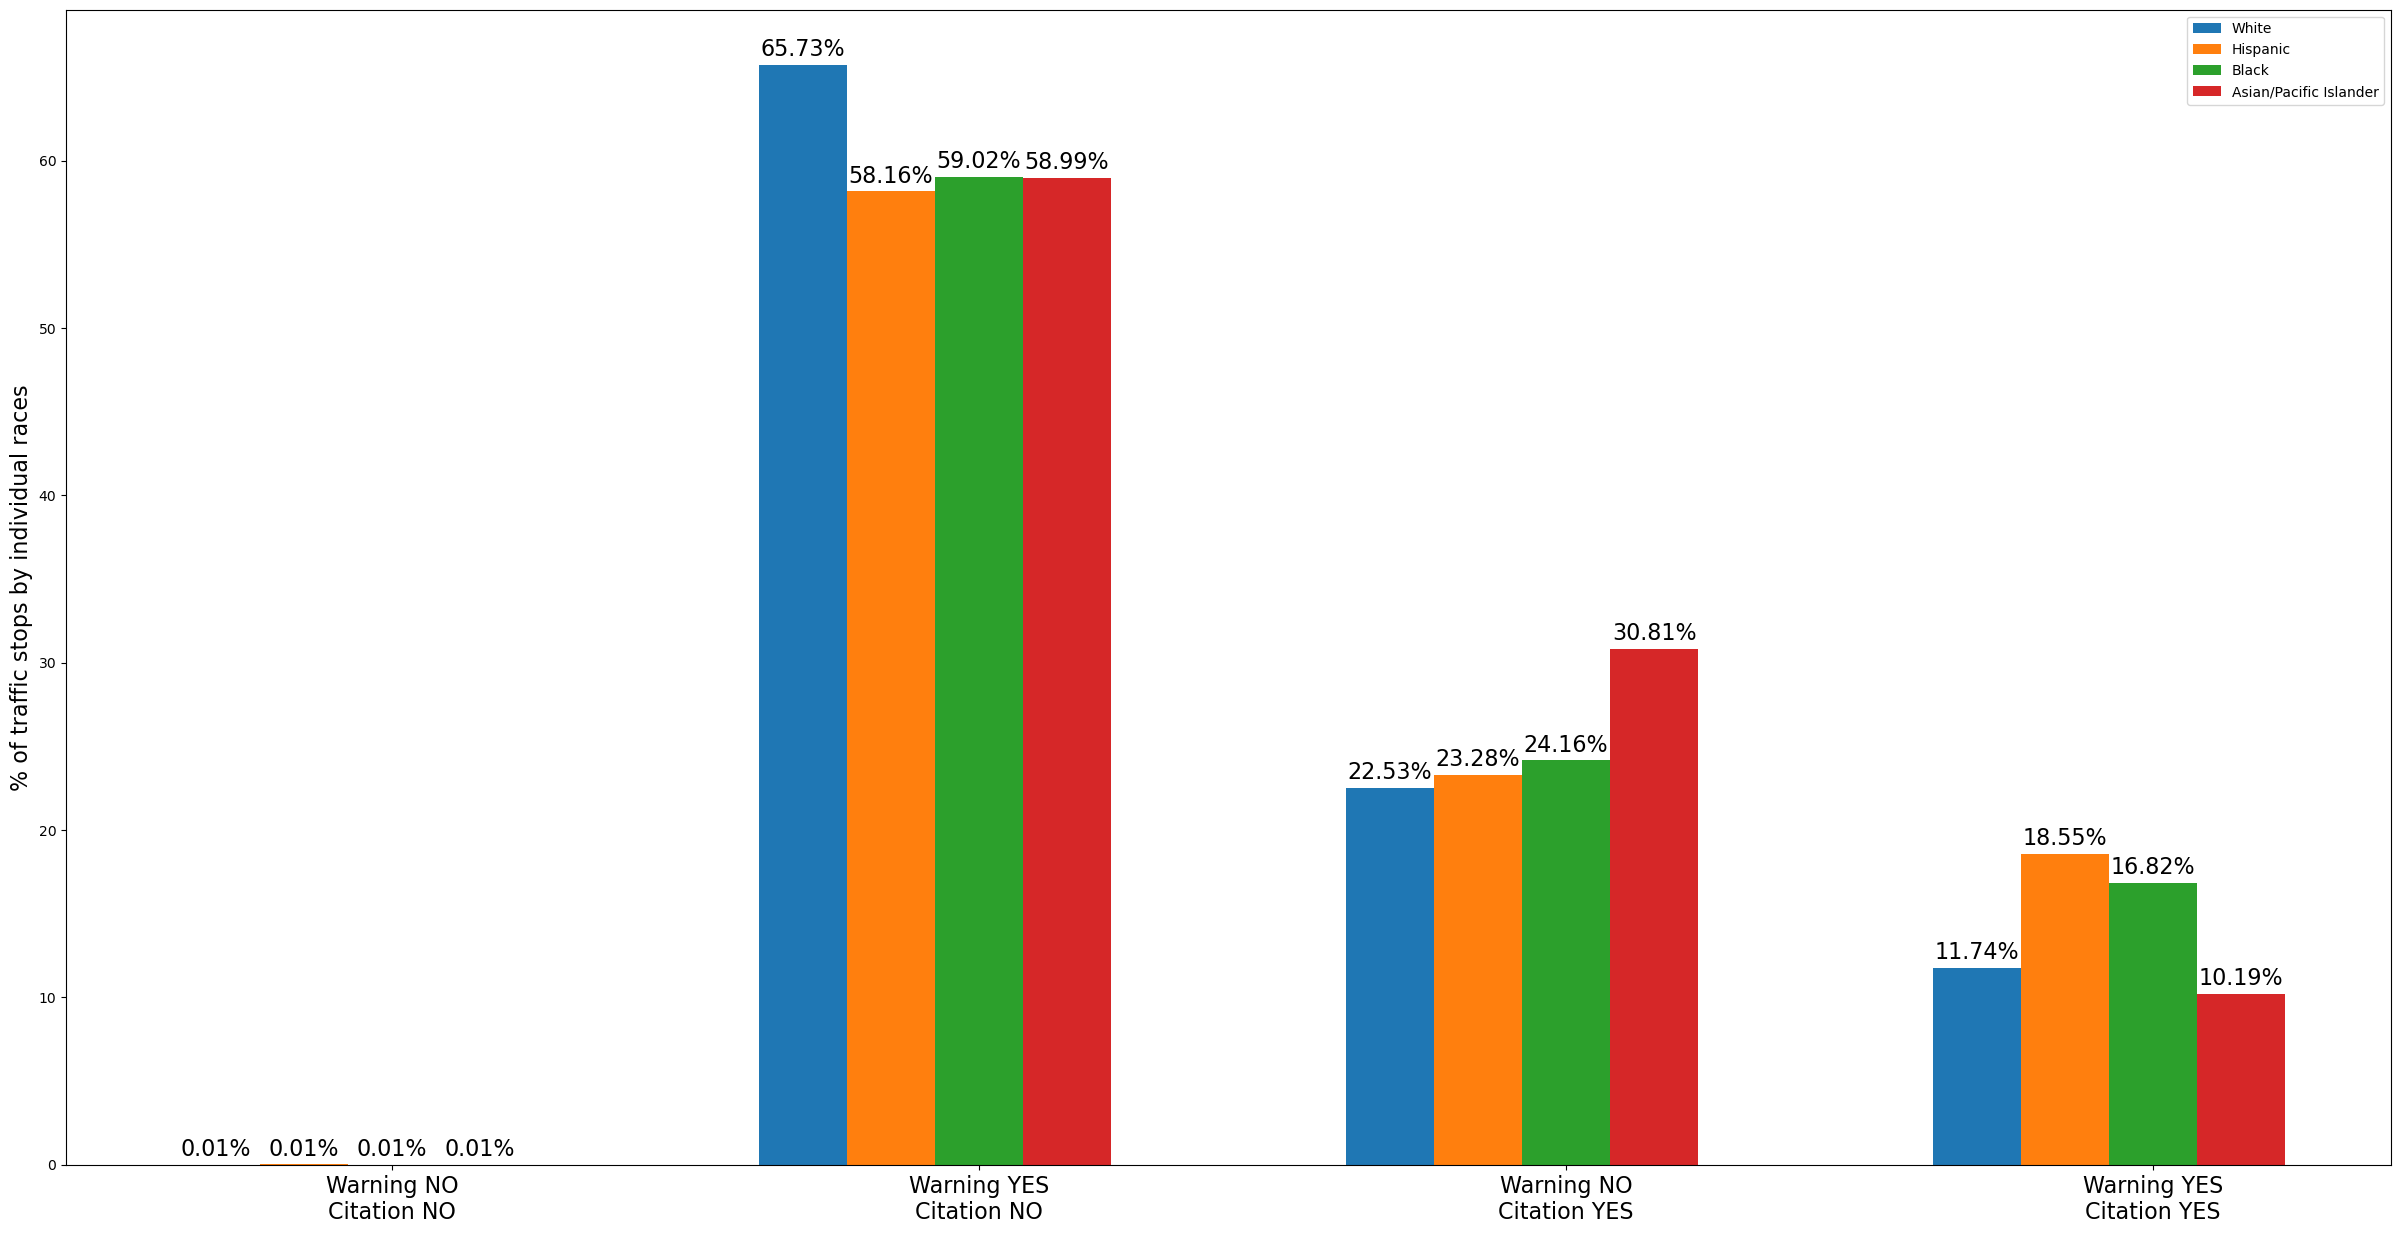

In [32]:
labels = ['Warning NO\nCitation NO', 'Warning YES\nCitation NO', 'Warning NO\nCitation YES', 'Warning YES\nCitation YES']

x = np.arange(len(labels))  # the label locations
width = 0.15 # the width of the bars

fig = plt.figure(figsize=(30,15))
ax = fig.add_subplot(111)
rects1 = ax.bar(x-2*width, percentage_dict['white'], width, label='White')
rects2 = ax.bar(x-width, percentage_dict['hispanic'], width, label='Hispanic')
rects3 = ax.bar(x, percentage_dict['black'], width, label='Black')
rects4 = ax.bar(x+width, percentage_dict['asian/pacific islander'], width, label='Asian/Pacific Islander')

ax.set_ylabel('% of traffic stops by individual races', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=16)
ax.legend()

format_str = '{:.2%}'
autolabel(rects1, ax, format_str)
autolabel(rects2, ax, format_str)
autolabel(rects3, ax, format_str)
autolabel(rects4, ax, format_str)

plt.show()


In [34]:
percentage_dict = {}

for cat1, cat2 in [('Warning=0_Citation=0', 'Warning=1_Citation=0'), ('Warning=0_Citation=1', 'Warning=1_Citation=1')]:
    percentage_dict[(cat1, cat2)] = []
    for race in ['white', 'black', 'hispanic', 'asian/pacific islander']:
        percentage_dict[(cat1, cat2)].append(100 * (count_df[count_df['Race'] == race][cat1].values[0] + count_df[count_df['Race'] == race][cat2].values[0]) / count_df[count_df['Race'] == race]['Total'].values[0])


In [35]:
percentage_dict

{('Warning=0_Citation=0', 'Warning=1_Citation=0'): [65.73377384797679,
  59.027015037894934,
  58.1695895342538,
  58.99220321505426],
 ('Warning=0_Citation=1', 'Warning=1_Citation=1'): [34.266226152023215,
  40.972984962105066,
  41.8304104657462,
  41.00779678494574]}

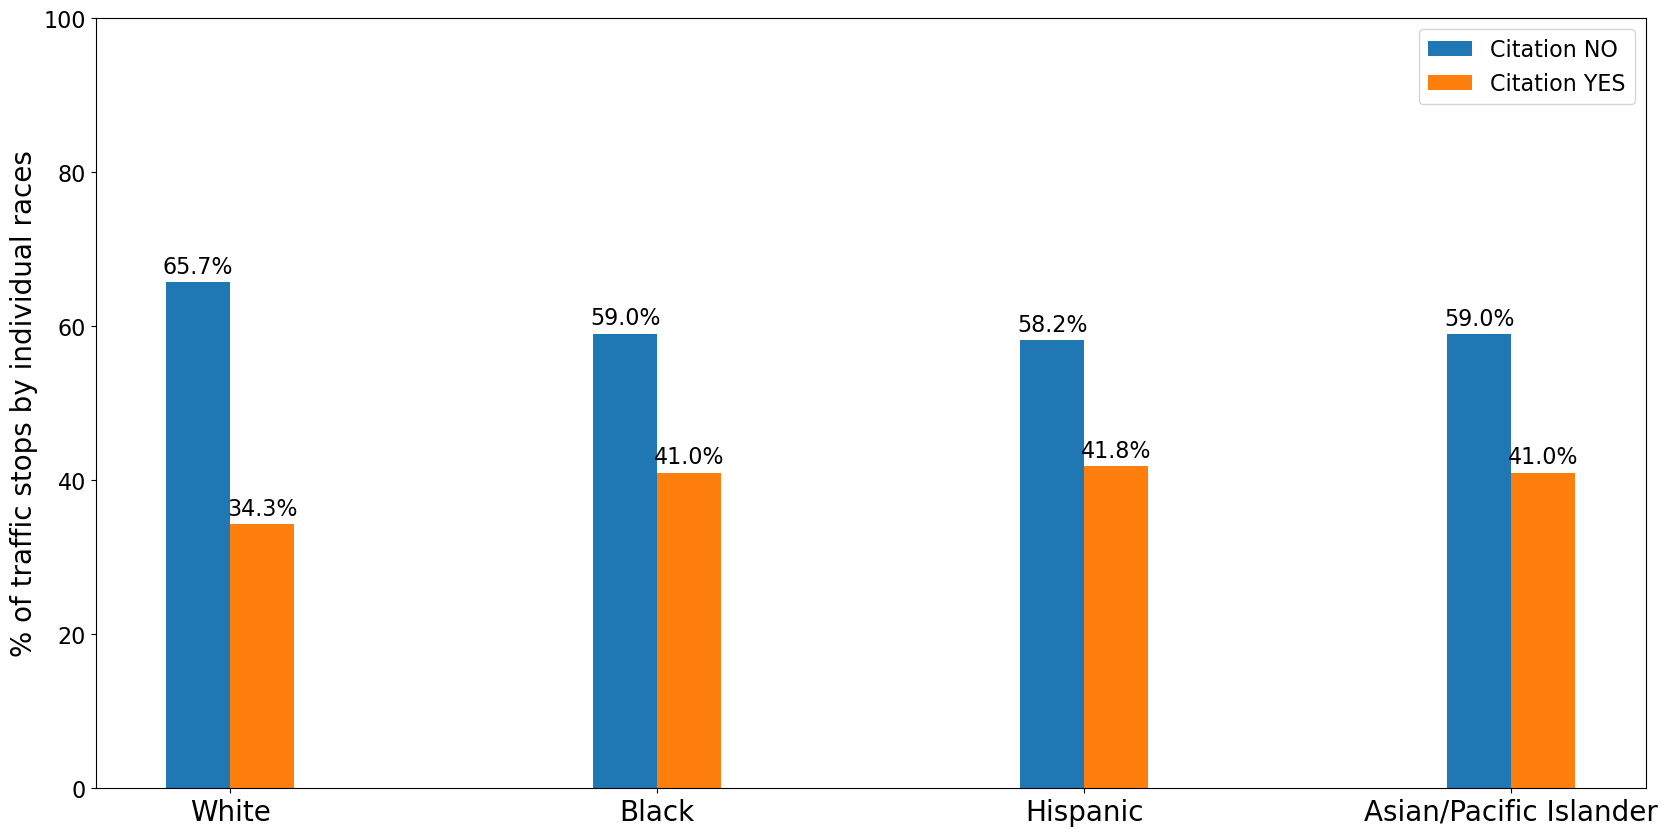

In [49]:
labels = ['White', 'Black', 'Hispanic', 'Asian/Pacific Islander']

x = np.arange(len(labels))  # the label locations

fig = plt.figure(figsize=(20,10))
ax2 = fig.add_subplot(111)
rects5 = ax2.bar(x - width/2, percentage_dict[('Warning=0_Citation=0', 'Warning=1_Citation=0')], width, label='Citation NO')
rects6 = ax2.bar(x + width/2, percentage_dict[('Warning=0_Citation=1', 'Warning=1_Citation=1')], width, label='Citation YES')

ax2.set_ylabel('% of traffic stops by individual races', fontsize=20)
ax2.tick_params(axis="y", labelsize=16)
ax2.set_ylim(0, 100)
ax2.set_xticks(x)
ax2.set_xticklabels(labels, fontsize=20)
ax2.legend(fontsize=16)
# plt.grid(True, axis='y')

format_str = '{:.1%}'
autolabel(rects5, ax2, format_str)
autolabel(rects6, ax2, format_str)


plt.savefig("C:\\Users\\19172\\Desktop\\Traffic\\stopsbyraces.jpg")
plt.show()

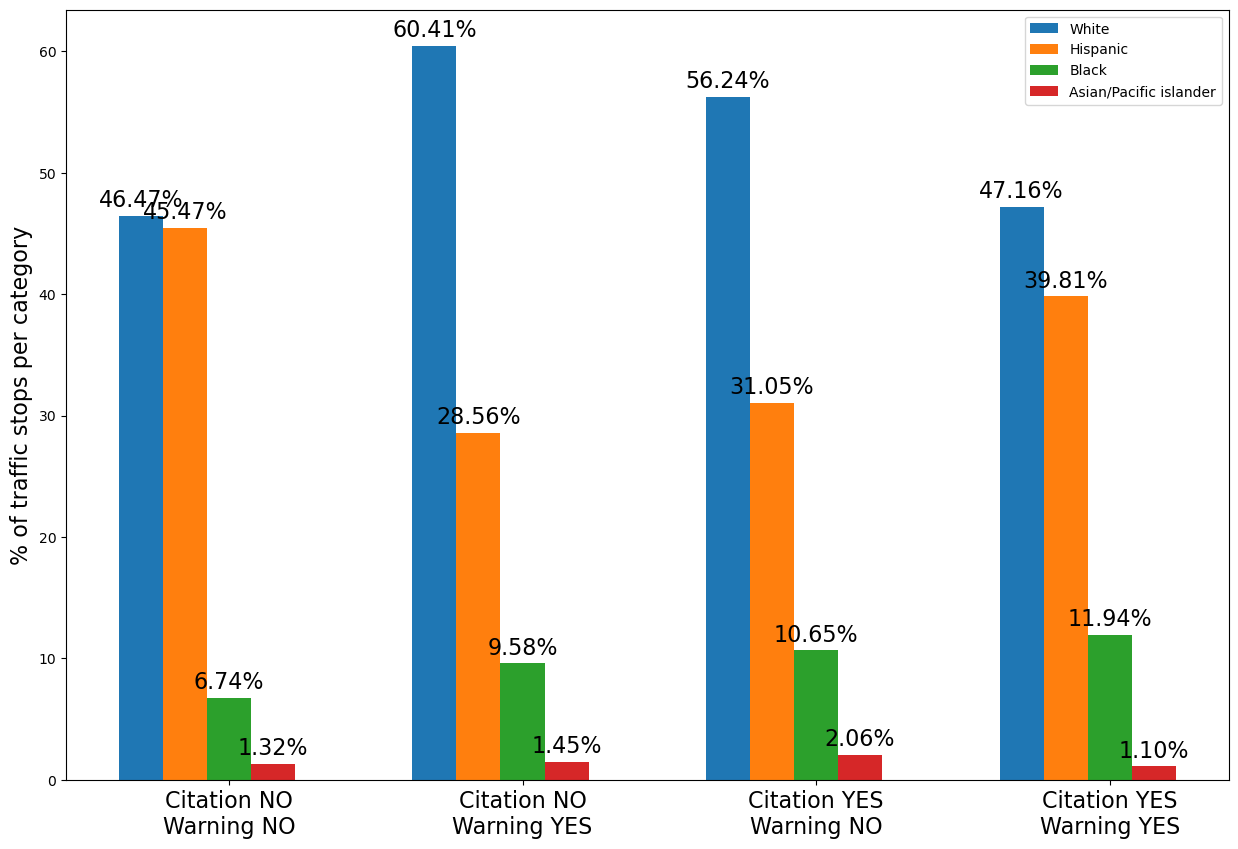

In [52]:
# Get info on how the races split up in 4 categories by percentage
percentage_dict_2a = {}

for race in ['white', 'black', 'hispanic', 'asian/pacific islander']:
    percentage_dict_2a[race] = []
    percentage_dict_2a[race].append(100 * count_df[count_df['Race'] == race]['Warning=0_Citation=0'].values[0] / count_df['Warning=0_Citation=0'].sum())
    percentage_dict_2a[race].append(100 * count_df[count_df['Race'] == race]['Warning=1_Citation=0'].values[0] / count_df['Warning=1_Citation=0'].sum())
    percentage_dict_2a[race].append(100 * count_df[count_df['Race'] == race]['Warning=0_Citation=1'].values[0] / count_df['Warning=0_Citation=1'].sum())
    percentage_dict_2a[race].append(100 * count_df[count_df['Race'] == race]['Warning=1_Citation=1'].values[0] / count_df['Warning=1_Citation=1'].sum())
labels = ['Citation NO\nWarning NO', 'Citation NO\nWarning YES', 'Citation YES\nWarning NO', 'Citation YES\nWarning YES']

x = np.arange(len(labels))  # the label locations

fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(111)
rects7 = ax1.bar(x - 2*width, percentage_dict_2a['white'], width, label='White')
rects8 = ax1.bar(x - width, percentage_dict_2a['hispanic'], width, label='Hispanic')
rects9 = ax1.bar(x, percentage_dict_2a['black'], width, label='Black')
rects10 = ax1.bar(x + width, percentage_dict_2a['asian/pacific islander'], width, label='Asian/Pacific islander')

ax1.set_ylabel('% of traffic stops per category', fontsize=16)
ax1.set_xticks(x)
ax1.set_xticklabels(labels, fontsize=16)
ax1.legend()

format_str = '{:.2%}'
autolabel(rects7, ax1, format_str)
autolabel(rects8, ax1, format_str)
autolabel(rects9, ax1, format_str)
autolabel(rects10, ax1, format_str)

plt.savefig("C:\\Users\\19172\\Desktop\\Traffic\\stopsbyraces2.jpg")
plt.show()

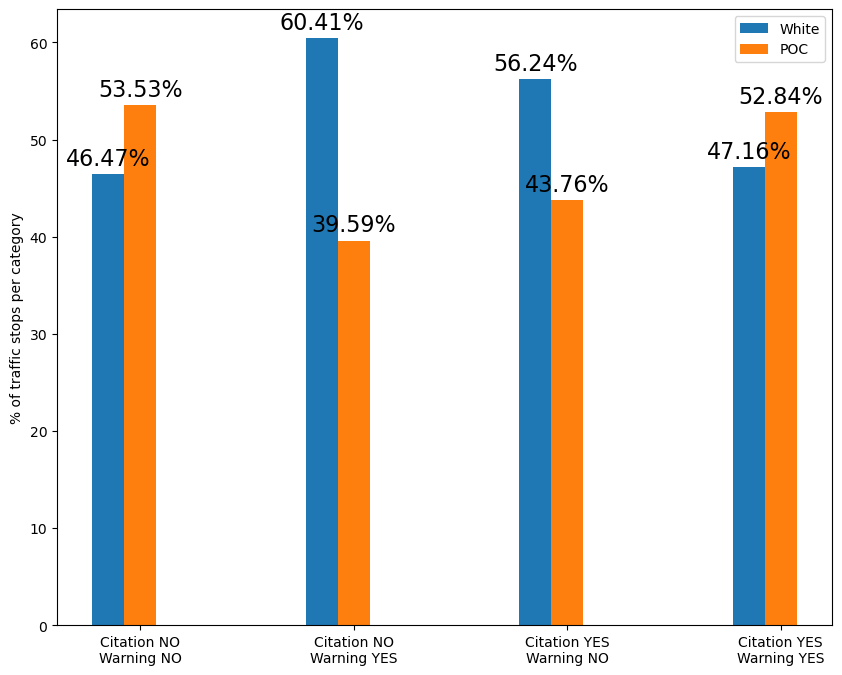

In [55]:
# Get info on how the races split up in 4 categories by percentage
percentage_dict = {}

for race in ['white', 'poc']:
    percentage_dict[race] = []
    
    if race == 'poc':
        percentage_dict[race].append(100 * (1 - count_df[count_df['Race'] == 'white']['Warning=0_Citation=0'].values[0] / count_df['Warning=0_Citation=0'].sum()))
        percentage_dict[race].append(100 * (1 - count_df[count_df['Race'] == 'white']['Warning=1_Citation=0'].values[0] / count_df['Warning=1_Citation=0'].sum()))
        percentage_dict[race].append(100 * (1 - count_df[count_df['Race'] == 'white']['Warning=0_Citation=1'].values[0] / count_df['Warning=0_Citation=1'].sum()))
        percentage_dict[race].append(100 * (1 - count_df[count_df['Race'] == 'white']['Warning=1_Citation=1'].values[0] / count_df['Warning=1_Citation=1'].sum()))
    else:
        percentage_dict[race].append(100 * count_df[count_df['Race'] == race]['Warning=0_Citation=0'].values[0] / count_df['Warning=0_Citation=0'].sum())
        percentage_dict[race].append(100 * count_df[count_df['Race'] == race]['Warning=1_Citation=0'].values[0] / count_df['Warning=1_Citation=0'].sum())
        percentage_dict[race].append(100 * count_df[count_df['Race'] == race]['Warning=0_Citation=1'].values[0] / count_df['Warning=0_Citation=1'].sum())
        percentage_dict[race].append(100 * count_df[count_df['Race'] == race]['Warning=1_Citation=1'].values[0] / count_df['Warning=1_Citation=1'].sum())
fig = plt.figure(figsize=(10,8))
ax3 = fig.add_subplot(111)
rects0 = ax3.bar(x - width, percentage_dict['white'], width, label='White')
rects11 = ax3.bar(x, percentage_dict['poc'], width, label='POC')

ax3.set_ylabel('% of traffic stops per category')
ax3.set_xticks(x)
ax3.set_xticklabels(labels)
ax3.legend()

format_str = '{:.2%}'
autolabel(rects0, ax3, format_str)
autolabel(rects11, ax3, format_str)

plt.savefig("C:\\Users\\19172\\Desktop\\Traffic\\stopsbyraces3.jpg")
plt.show()

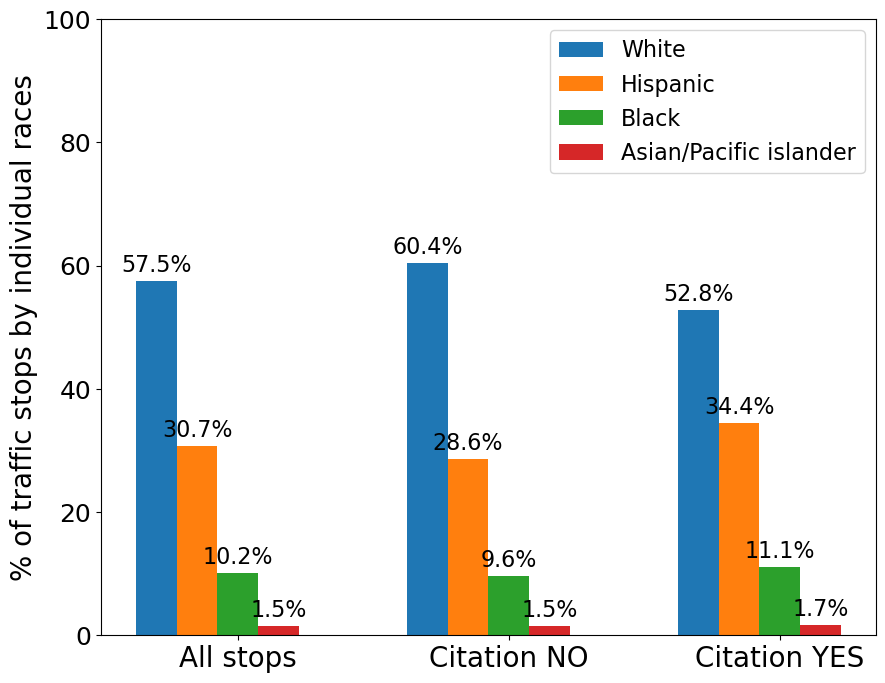

In [57]:
percentage_dict = {}

for race in ['white', 'hispanic', 'black', 'asian/pacific islander']:
    percentage_dict[race] = []
    
    percentage_dict[race].append(100 * count_df[count_df['Race'] == race]['Total'].values[0] / count_df['Total'].sum())
    percentage_dict[race].append(100 * (count_df[count_df['Race'] == race]['Warning=0_Citation=0'].values[0] + count_df[count_df['Race'] == race]['Warning=1_Citation=0'].values[0])/(count_df['Warning=0_Citation=0'].sum() + count_df['Warning=1_Citation=0'].sum()))
    percentage_dict[race].append(100 * (count_df[count_df['Race'] == race]['Warning=0_Citation=1'].values[0] + count_df[count_df['Race'] == race]['Warning=1_Citation=1'].values[0])/(count_df['Warning=0_Citation=1'].sum() + count_df['Warning=1_Citation=1'].sum()))
labels = ['All stops', 'Citation NO', 'Citation YES']

x = np.arange(len(labels))  # the label locations

fig = plt.figure(figsize=(10,8))
ax2 = fig.add_subplot(111)
rects4 = ax2.bar(x - 2*width, percentage_dict['white'], width, label='White')
rects5 = ax2.bar(x - width, percentage_dict['hispanic'], width, label='Hispanic')
rects6 = ax2.bar(x, percentage_dict['black'], width, label='Black')
rects7 = ax2.bar(x + width, percentage_dict['asian/pacific islander'], width, label='Asian/Pacific islander')

ax2.set_ylabel('% of traffic stops by individual races', fontsize=20)
ax2.tick_params(axis="y", labelsize=18)
ax2.set_ylim(0,100)
ax2.set_xticks(x)
ax2.set_xticklabels(labels, fontsize=20)
ax2.legend(fontsize=16)

format_str = '{:.1%}'
autolabel(rects4, ax2, format_str)
autolabel(rects5, ax2, format_str)
autolabel(rects6, ax2, format_str)
autolabel(rects7, ax2, format_str)

plt.savefig("C:\\Users\\19172\\Desktop\\Traffic\\stopsbyraces4.jpg")
plt.show()


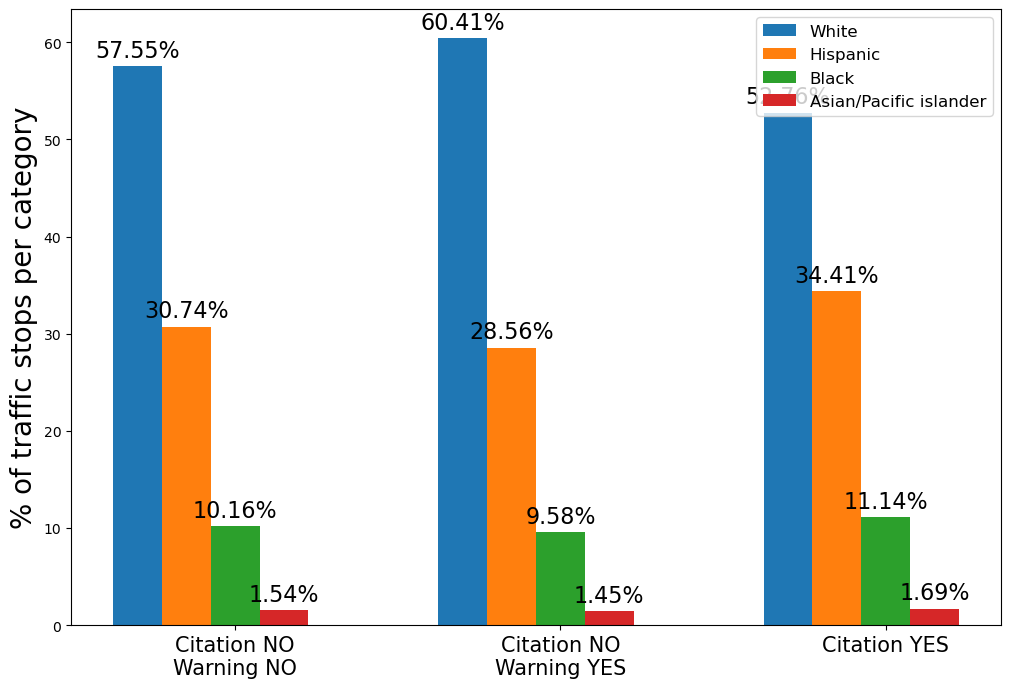

In [59]:
labels = ['Citation NO\nWarning NO', 'Citation NO\nWarning YES', 'Citation YES']

x = np.arange(len(labels))  # the label locations
fig4 = plt.figure(figsize=(12,8))
ax4 = fig4.add_subplot(111)
rects12 = ax4.bar(x - 2*width, percentage_dict['white'], width, label='White')
rects13 = ax4.bar(x - width, percentage_dict['hispanic'], width, label='Hispanic')
rects14 = ax4.bar(x, percentage_dict['black'], width, label='Black')
rects15 = ax4.bar(x + width, percentage_dict['asian/pacific islander'], width, label='Asian/Pacific islander')

ax4.set_ylabel('% of traffic stops per category', fontsize=20)
ax4.set_xticks(x)
ax4.set_xticklabels(labels, fontsize=15)
ax4.legend(fontsize=12)

format_str = '{:.2%}'
autolabel(rects12, ax4, format_str)
autolabel(rects13, ax4, format_str)
autolabel(rects14, ax4, format_str)
autolabel(rects15, ax4, format_str)


plt.savefig("C:\\Users\\19172\\Desktop\\Traffic\\stopsbyraces5.jpg")
plt.show()